There are 45,211 observations and 17 attributes in the data set


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,contacted_previously,positive_balance
15406,48,housemaid,divorced,primary,no,1583,no,yes,telephone,18,jul,494,2,-1,0,unknown,no,False,True
20010,48,blue-collar,married,secondary,no,2083,no,no,cellular,8,aug,88,3,-1,0,unknown,no,False,True
23108,57,services,married,secondary,no,1113,no,no,cellular,26,aug,264,20,-1,0,unknown,no,False,True
21221,32,technician,single,tertiary,no,3818,no,no,cellular,18,aug,100,4,-1,0,unknown,no,False,True
17750,41,unemployed,married,primary,no,183,yes,no,cellular,29,jul,271,1,-1,0,unknown,no,False,True


marital             : Counter({'married': 21715, 'single': 10285, 'divorced': 4168})
education           : Counter({'secondary': 18480, 'tertiary': 10745, 'primary': 5467, 'unknown': 1476})
default             : Counter({'no': 35532, 'yes': 636})
poutcome            : Counter({'unknown': 29564, 'failure': 3931, 'other': 1489, 'success': 1184})
contacted_previously: Counter({False: 29560, True: 6608})
housing             : Counter({'yes': 20049, 'no': 16119})
loan                : Counter({'no': 30400, 'yes': 5768})
contact             : Counter({'cellular': 23438, 'unknown': 10413, 'telephone': 2317})
job                 : Counter({'blue-collar': 7738, 'management': 7673, 'technician': 6057, 'admin.': 4103, 'services': 3328, 'retired': 1803, 'self-employed': 1264, 'entrepreneur': 1176, 'unemployed': 1069, 'housemaid': 979, 'student': 749, 'unknown': 229})


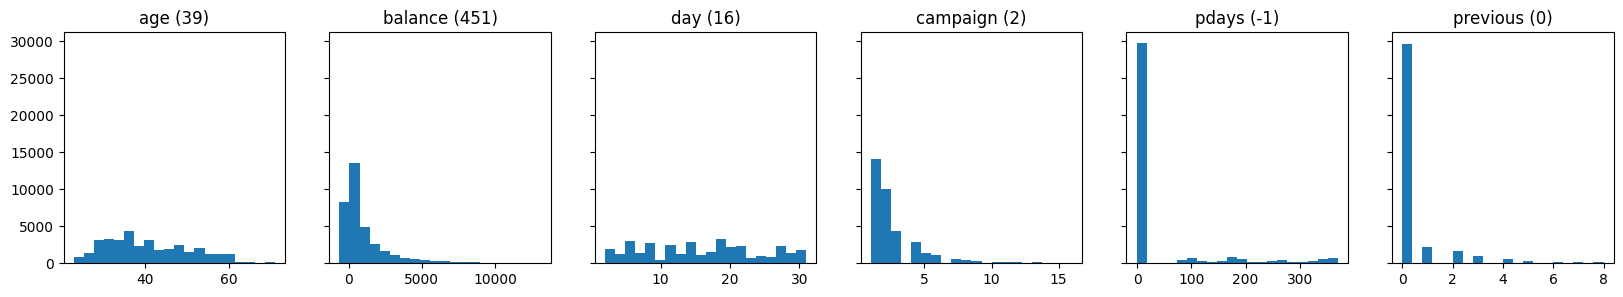

In [1]:
from collections import Counter
from typing import List, Tuple

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBClassifier

np.random.seed(1516)
torch.manual_seed(1516)

_CAT_COLS = ["marital", "education", "default", "poutcome", "contacted_previously", "housing", "loan", "contact", "job"]
_CONT_COLS = ["age", "balance", "day", "campaign", "pdays", "previous"]
_TARGET_COL = "y"

def read_data():
    data = pd.read_csv("../data/bank-full.csv", sep = ";")
    print(f"There are {data.shape[0]:,} observations and {data.shape[1]:,} attributes in the data set")
    data["contacted_previously"] = data["pdays"] != -1
    data["positive_balance"] = data["balance"] > 0
    return data

data = read_data()
train, valid = train_test_split(data, test_size = 0.2)

display(train.head())

fig, axs = plt.subplots(ncols=len(_CONT_COLS), sharey=True, figsize=(20,3))
for i, col in enumerate(_CONT_COLS):
    quant = train[[col]].quantile([.01, .5, .99]).values
    p01, p50, p99 = quant[0][0], quant[1][0], quant[2][0]
    axs[i].hist(train[[col]], range=(p01, p99), bins=20)
    axs[i].set_title(f"{col} ({p50:.0f})")
    
for col in _CAT_COLS:
    print(f"{col:20}: {Counter(train[col])}")

In [2]:
def preproc_fit(df):
    cat_preproc = make_column_transformer(
        (
            OrdinalEncoder(categories="auto"),
            _CAT_COLS,
        ),
        remainder = "drop",
        )

    cont_preproc = make_column_transformer(
        (
            StandardScaler(),
            _CONT_COLS,
        ),
        remainder = "drop",
    )

    label_preproc = LabelEncoder()

    cat_preproc.fit(df)
    cont_preproc.fit(df)
    label_preproc.fit(df[_TARGET_COL])
    return cat_preproc, cont_preproc, label_preproc


def preproc_transform(df: pd.DataFrame, cat_preproc, cont_preproc, label_preproc) -> [pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_cat_preprocess = cat_preproc.transform(df)
    X_cont_preprocess = cont_preproc.transform(df)
    y_preprocess = label_preproc.transform(df[_TARGET_COL])

    return X_cat_preprocess, X_cont_preprocess, y_preprocess

class BankingData(Dataset):

    def __init__(self, X_cat, X_cont, y):
        self.X_cat = X_cat
        self.X_cont = X_cont
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]

def get_dataloader(df: pd.DataFrame, batch_size: int, shuffle: bool, preprocs = Tuple) -> DataLoader:
    X_cat, X_cont, y = preproc_transform(df, *preprocs)
    X_cat_tensor = torch.tensor(X_cat, dtype = torch.long)
    X_cont_tensor = torch.tensor(X_cont, dtype = torch.float32)
    y_tensor = torch.tensor(y, dtype = torch.long)

    dataset = BankingData(X_cat_tensor, X_cont_tensor, y_tensor)
    return DataLoader(dataset, batch_size = batch_size, shuffle=shuffle)


In [3]:
class FeedForward(nn.Module):

    def __init__(self, in_features, out_features):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features)
        )
        
    def forward(self, x):
        return self.net(x)

class InputMapper(nn.Module):

    def __init__(self, num_cont_features: int, emb_input_outputs: List[Tuple[int,int]], out_size: int, dropout: float):
        super(InputMapper, self).__init__()
        self.category_input1 = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_input_outputs])
        self.category_input2 = nn.Dropout(dropout)
        embeding_output_dim = sum([eio[1] for eio in emb_input_outputs])
        self.continuous_input = nn.BatchNorm1d(num_cont_features)
        self.combined_input = nn.Sequential(
            nn.Linear(embeding_output_dim + num_cont_features, out_size),
            nn.ReLU(),
            nn.BatchNorm1d(out_size),
        )

    def forward(self, X_cat, X_cont):
        X_cat = torch.cat([emb(X_cat[:,i]) for i,emb in enumerate(self.category_input1)], 1)
        X_cat = self.category_input2(X_cat)
        X_cont = self.continuous_input(X_cont)
        return self.combined_input(torch.cat([X_cat, X_cont], dim=1))
        
class NeuralNetwork(nn.Module):
    
    def __init__(self, num_cont_features: int, emb_input_outputs: List[Tuple[int,int]], out_size: int, dropout: float, n_layers = 2):
        super(NeuralNetwork, self).__init__()
        self.input = InputMapper(num_cont_features, emb_input_outputs, out_size, dropout)
        self.feedforward = nn.Sequential(*[FeedForward(out_size, out_size) for _ in range(n_layers)])
        self.output = nn.Linear(out_size, 2)
    
    def forward(self, X_cat, X_cont, y):
        X = self.input(X_cat, X_cont)
        X = self.feedforward(X)
        logits = self.output(X)
        loss = F.cross_entropy(logits, y)
        return logits, loss

In [4]:
preprocs = preproc_fit(train)

train_dataloader = get_dataloader(train, batch_size=400, shuffle=True, preprocs = preprocs)
valid_dataloader = get_dataloader(valid, batch_size=400, shuffle=True, preprocs = preprocs)

cat_szs = [train[col].nunique() for col in _CAT_COLS]
emb_ios = [(size, min(50, (size+1)//2)) for size in cat_szs]

model = NeuralNetwork(num_cont_features = len(_CONT_COLS), emb_input_outputs = emb_ios, out_size = 100, dropout = 0.1)
print(f"Model has {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
model

Model has 0.0M parameters


NeuralNetwork(
  (input): InputMapper(
    (category_input1): ModuleList(
      (0): Embedding(3, 2)
      (1): Embedding(4, 2)
      (2): Embedding(2, 1)
      (3): Embedding(4, 2)
      (4-6): 3 x Embedding(2, 1)
      (7): Embedding(3, 2)
      (8): Embedding(12, 6)
    )
    (category_input2): Dropout(p=0.1, inplace=False)
    (continuous_input): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (combined_input): Sequential(
      (0): Linear(in_features=24, out_features=100, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (feedforward): Sequential(
    (0): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=10

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

train_losses = []
valid_losses = []
steps = []

for step in range(2000):
    
    model.train()
    xb_cat, xb_cont, yb = next(iter(train_dataloader))
    logits, loss = model(xb_cat, xb_cont, yb)

    train_losses.append(loss.item())
    steps.append(step)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        xb_cat_valid, xb_cont_valid, yb_valid = next(iter(valid_dataloader))
        logits_valid, loss_valid = model(xb_cat_valid, xb_cont_valid, yb_valid)
        
        valid_losses.append(loss_valid)
        
    if step % 100 == 0:
        print(f"Step {step:5}: loss (T) = {np.mean(train_losses[-100:]):.4f}, loss (V) = {np.mean(valid_losses[-100:]):.4f}")

Step     0: loss (T) = 0.7723, loss (V) = 0.7411
Step   100: loss (T) = 0.6772, loss (V) = 0.6852
Step   200: loss (T) = 0.5460, loss (V) = 0.5323
Step   300: loss (T) = 0.4128, loss (V) = 0.4099
Step   400: loss (T) = 0.3373, loss (V) = 0.3425
Step   500: loss (T) = 0.3129, loss (V) = 0.3273
Step   600: loss (T) = 0.3090, loss (V) = 0.3204
Step   700: loss (T) = 0.3011, loss (V) = 0.3140
Step   800: loss (T) = 0.3047, loss (V) = 0.3197
Step   900: loss (T) = 0.3039, loss (V) = 0.3234
Step  1000: loss (T) = 0.2987, loss (V) = 0.3162
Step  1100: loss (T) = 0.2985, loss (V) = 0.3203
Step  1200: loss (T) = 0.2947, loss (V) = 0.3173
Step  1300: loss (T) = 0.2966, loss (V) = 0.3222
Step  1400: loss (T) = 0.2937, loss (V) = 0.3245
Step  1500: loss (T) = 0.2962, loss (V) = 0.3158
Step  1600: loss (T) = 0.2911, loss (V) = 0.3218
Step  1700: loss (T) = 0.2931, loss (V) = 0.3218
Step  1800: loss (T) = 0.2902, loss (V) = 0.3216
Step  1900: loss (T) = 0.2910, loss (V) = 0.3232


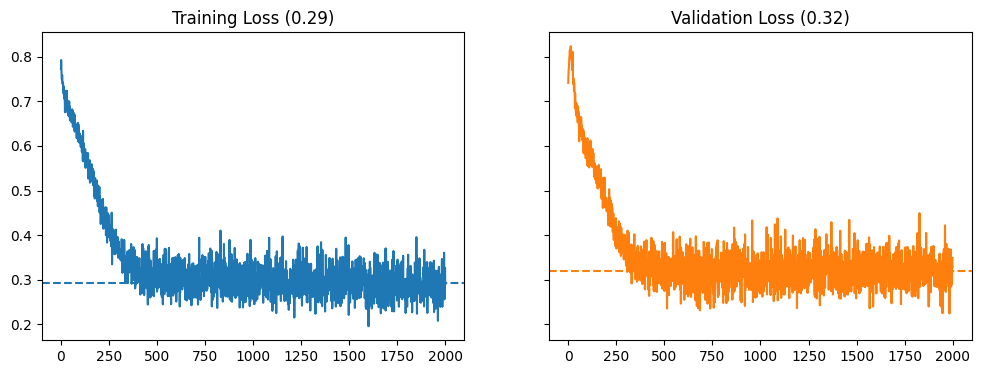

In [6]:
def plot_loss(steps, train_losses, valid_losses):
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))
    axs[0].plot(steps, train_losses, label = "Training", color = 'C0')
    axs[0].axhline(y = np.mean(train_losses[-1000:]), color = 'C0', linestyle = '--')
    axs[0].set_title(f"Training Loss ({np.mean(train_losses[-1000:]):.2f})")
    axs[1].plot(steps, valid_losses, label = "Validation", color = '#ff7f0e')
    axs[1].axhline(y = np.mean(valid_losses[-1000:]), color = '#ff7f0e', linestyle = '--')
    axs[1].set_title(f"Validation Loss ({np.mean(valid_losses[-1000:]):.2f})")
    return axs

axs = plot_loss(steps, train_losses, valid_losses)

In [7]:
def evaluate(y_obs, pred_proba, mode, model_name, threshold = 0.5):
    preds = pred_proba >= threshold
    report_dict = classification_report(y_obs, preds, output_dict=True)["1"]
    del report_dict["support"]
    report_dict["roc_auc"] = roc_auc_score(y_obs, pred_proba)
    report_dict["accuracy"] = accuracy_score(y_obs, preds)
    report_dict["mode"] = mode
    report_dict["model"] = model_name
    return report_dict

def evaluate_nn(dataloader, model, mode):
    model.eval()
    
    y_obs = []
    pred_proba = []

    with torch.no_grad():
        for xb_cat, xb_cont, yb in dataloader:
            logits, _ = model(xb_cat, xb_cont, yb)
            y_obs.append(yb.numpy())
            pred_proba.append(F.softmax(logits, dim=1)[:,1].numpy())

    y_obs = np.concatenate(y_obs)
    pred_proba = np.concatenate(pred_proba)
    return evaluate(y_obs, pred_proba, mode=mode, model_name = "Neural Network")

def train_xgb(df_train, df_valid):
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

    cat_preproc, cont_preproc, y_preproc = preproc_fit(df_train)
    X_cat, X_cont, y_train = preproc_transform(df_train, cat_preproc, cont_preproc, y_preproc)
    X_train = np.concatenate([X_cat, X_cont], axis=1)
    bst.fit(X_train, y_train)
    preds_train = bst.predict_proba(X_train)[:,1]

    X_cat_valid, X_cont_valid, y_valid = preproc_transform(df_train, cat_preproc, cont_preproc, y_preproc)
    X_valid = np.concatenate([X_cat_valid, X_cont_valid], axis=1)
    preds_valid = bst.predict_proba(X_valid)[:,1]
    return (preds_train, y_train), (preds_valid, y_valid)

def display_metrics(report_dicts):
    table = pd.concat([pd.DataFrame(rd, index=[i]) for i, rd in enumerate(report_dicts)])
    return table.set_index(["model", "mode"])


train_nn = evaluate_nn(train_dataloader, model, "Train")
valid_nn = evaluate_nn(valid_dataloader, model, "Valid")

(preds_train, y_train), (preds_valid, y_valid) = train_xgb(train, valid)
train_xgb = evaluate(y_train, preds_train, "Train", model_name = "XGBoost")
valid_xgb = evaluate(y_valid, preds_valid, "Valid", model_name = "XGBoost")

display_metrics([train_nn, valid_nn, train_xgb, valid_xgb])

precision    recall  f1-score   roc_auc  accuracy
model          mode                                                    
Neural Network Train   0.727055  0.215723  0.332725  0.816345  0.898971
               Valid   0.593472  0.187617  0.285103  0.734311  0.889085
XGBoost        Train   0.655202  0.180440  0.282956  0.724101  0.893221
               Valid   0.655202  0.180440  0.282956  0.724101  0.893221